<a href="https://colab.research.google.com/github/MRezaGhorbani/C_Programming/blob/main/Models/newDistributed/paper3_classifier_ReR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preprocess**

In [ ]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling1D, SimpleRNN, Dense, Dropout, Input, Flatten, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# ----------------------------------------------------------------------
# 1) Load input_files, label_files, selected_features,
#    and perform data loading just like in your original code.
# ----------------------------------------------------------------------

input_files = [
    "Input_Train_de.mat", "Input_Train_Ax.mat", "Input_Train_Ay.mat",
    "Input_Train_Az.mat", "Input_Train_p.mat", "Input_Train_q.mat",
    "Input_Train_r.mat", "Input_Train_Z.mat", "Input_Train_W.mat",
    "Input_Train_T.mat", "Input_Train_Wind.mat", "Input_Train_Road.mat",
    "Input_Train_m.mat", "Input_Train_mu.mat", "Input_Train_Re.mat"
]

label_files = [
    "Label_Train_de.mat", "Label_Train_Ax.mat", "Label_Train_Ay.mat",
    "Label_Train_Az.mat", "Label_Train_p.mat", "Label_Train_q.mat",
    "Label_Train_r.mat", "Label_Train_Z.mat", "Label_Train_W.mat",
    "Label_Train_T.mat", "Label_Train_Wind.mat", "Label_Train_Road.mat",
    "Label_Train_m.mat", "Label_Train_mu.mat", "Label_Train_Re.mat"
]

selected_features = [0, 21, 22, 23, 24, 25, 26]  # 0-indexed


# Load and concatenate all input and label data
all_inputs = []
all_labels = []
for input_file, label_file in zip(input_files, label_files):
    input_data = scipy.io.loadmat(input_file)['Inputs']
    label_data = scipy.io.loadmat(label_file)['Labels']

    for i in range(input_data.shape[1]):
        # Extract only selected features
        all_inputs.append(input_data[0, i][selected_features, :])
        # Encode only 'ReR1' fault as 1, everything else as 0
        all_labels.append(np.where(label_data[0, i] == 27, 1, 0))

# Convert lists to numpy arrays
all_inputs = np.concatenate(all_inputs, axis=1)  # shape: (num_features, total_timesteps)
all_labels = np.concatenate(all_labels, axis=1)  # shape: (1, total_timesteps)

# ----------------------------------------------------------------------
# 2) Build 40-step windows, labeling each window by the *last* step's label
# ----------------------------------------------------------------------
window_size = 40
X_simulations = []
y_simulations = []

for t in range(all_inputs.shape[1] - window_size + 1):
    # Extract a 40-step window of features
    X_simulations.append(all_inputs[:, t : t + window_size].T)  # shape: (40, num_features)

    # Label = the last step in this 40-step window
    window_label = all_labels[0, t + window_size - 1]
    y_simulations.append(window_label)

X_combined = np.array(X_simulations)  # shape: (num_windows, 40, num_features)
y_combined = np.array(y_simulations)  # shape: (num_windows,)

##############################################################################
# 2) Downsample the majority class (label=0) to be exactly 2× label=1 for training
##############################################################################

print("Before balancing:")
print(f"  Total samples: {len(y_combined)}")
print(f"  Label=0: {np.sum(y_combined == 0)}")
print(f"  Label=1: {np.sum(y_combined == 1)}")

pos_indices = np.where(y_combined == 1)[0]  # minority class
neg_indices = np.where(y_combined == 0)[0]  # majority class

n_pos = len(pos_indices)
n_neg = len(neg_indices)

# Desired number of negatives for training is 2× the number of positives
desired_neg = 3 * n_pos

# Shuffle negative indices so we pick them randomly
np.random.shuffle(neg_indices)

# If we have more negatives than needed, keep the desired amount for training
# and store the leftover for validation
if n_neg > desired_neg:
    neg_train_indices = neg_indices[:desired_neg]
    leftover_neg_indices = neg_indices[desired_neg:]  # not used in training
else:
    # If we don't have enough neg to reach 2×, we just keep them all
    neg_train_indices = neg_indices
    leftover_neg_indices = np.array([])  # no leftovers

# Now define the balanced training indices for features & labels
train_indices_balanced = np.concatenate([pos_indices, neg_train_indices])
np.random.shuffle(train_indices_balanced)  # shuffle them

# Create balanced sets for training only
X_balanced = X_combined[train_indices_balanced]
y_balanced = y_combined[train_indices_balanced]

print("\nAfter balancing for training:")
print(f"  Training samples (balanced): {len(y_balanced)}")
print("  Label=0 in training:", np.sum(y_balanced == 0))
print("  Label=1 in training:", np.sum(y_balanced == 1))

##############################################################################
# 3) Split the balanced data into train and validation sets
##############################################################################
X_train_bal, X_val_bal, y_train_bal, y_val_bal = train_test_split(
    X_balanced,
    y_balanced,
    test_size=0.2,
    random_state=39
)

##############################################################################
# 4) Append leftover negative samples (not used in training) to the validation set
##############################################################################
if leftover_neg_indices.size > 0:
    # Extract those leftover negative windows from the original X_combined, y_combined
    X_leftover_neg = X_combined[leftover_neg_indices]
    y_leftover_neg = y_combined[leftover_neg_indices]  # these are all 0

    print(f"\nAppending leftover negatives to validation set: {len(y_leftover_neg)} samples")

    # Concatenate to validation
    X_val = np.concatenate([X_val_bal, X_leftover_neg], axis=0)
    y_val = np.concatenate([y_val_bal, y_leftover_neg], axis=0)
else:
    # If there are no leftover negatives, just use the original split
    X_val = X_val_bal
    y_val = y_val_bal

# Finally, define X_train, y_train from the balanced portion
X_train = X_train_bal
y_train = y_train_bal

# Optionally, shuffle the final validation set so that leftover negatives
# don't appear in a block at the end
val_indices = np.arange(len(X_val))
np.random.shuffle(val_indices)
X_val = X_val[val_indices]
y_val = y_val[val_indices]

##############################################################################
# 5) Print final dataset shapes and label counts
##############################################################################
print("\nFinal sets:")
print(f"X_train_bal: {X_train_bal.shape}, y_train: {y_train_bal.shape}")
print(f"X_val_bal:   {X_val_bal.shape},   y_val:   {y_val_bal.shape}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print("Train set distribution:")
print("  Label=0:", np.sum(y_train == 0))
print("  Label=1:", np.sum(y_train == 1))
print("Validation set distribution:")
print("  Label=0:", np.sum(y_val == 0))
print("  Label=1:", np.sum(y_val == 1))

Before balancing:
  Total samples: 377228
  Label=0: 371380
  Label=1: 5848

After balancing for training:
  Training samples (balanced): 23392
  Label=0 in training: 17544
  Label=1 in training: 5848

Appending leftover negatives to validation set: 353836 samples

Final sets:
X_train_bal: (18713, 40, 4), y_train: (18713,)
X_val_bal:   (4679, 40, 4),   y_val:   (4679,)
X_train: (18713, 40, 4), y_train: (18713,)
X_val:   (358515, 40, 4),   y_val:   (358515,)
Train set distribution:
  Label=0: 14048
  Label=1: 4665
Validation set distribution:
  Label=0: 357332
  Label=1: 1183


# **Model Training**

In [ ]:
# Model definition
input_layer = Input(shape=(window_size, len(selected_features)))

x = Conv1D(filters=8, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = SimpleRNN(units=8, return_sequences=False)(x)
x = Dense(units=4, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output_layer = Dense(units=1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
model.fit(X_train_bal, y_train_bal, validation_data=(X_val_bal, y_val_bal), epochs=30, batch_size=256)

# Save the model
model.save('27_classifier_ReR1.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 40, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 38, 8)               │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 19, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 281 (1.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7265 - loss: 0.6611 - val_accuracy: 0.7472 - val_loss: 0.5908
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7615 - loss: 0.6077 - val_accuracy: 0.8348 - val_loss: 0.5098
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7883 - loss: 0.5610 - val_accuracy: 0.8444 - val_loss: 0.4729
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7977 - loss: 0.5379 - val_accuracy: 0.8660 - val_loss: 0.4239
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8083 - loss: 0.4816 - val_accuracy: 0.8741 - val_loss: 0.3887
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8156 - loss: 0.4401 - val_accuracy: 0.8805 - val_loss: 0.3656
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8145 - loss: 0.4308 - val_accuracy: 0.8820 - val_loss: 0.3420
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8178 - loss: 0.4020 - val_accuracy: 0.8839 - v

# **Validation**

11204/11204 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step


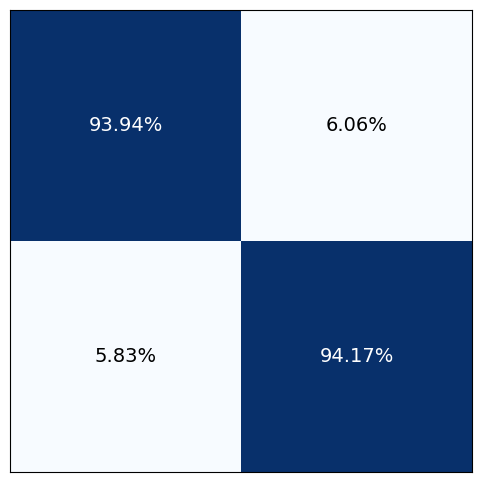

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('27_classifier_ReR1.h5')

# Predict on the validation data
y_pred_prob = model.predict(X_val)

# Convert predicted probabilities to binary class labels (threshold = 0.5 for binary classification)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# `y_val` is already binary in this case
y_true = y_val

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by row (true labels) to get percentages
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix without the color bar and title
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(conf_matrix_normalized, cmap=plt.cm.Blues)

# Remove axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])

# Display the percentage values in the cells with a larger font size
threshold = conf_matrix_normalized.max() / 2.0

for (i, j), val in np.ndenumerate(conf_matrix_normalized):
    color = 'white' if conf_matrix_normalized[i, j] > threshold else 'black'
    ax.text(j, i, f'{val:.2f}%', ha='center', va='center', color=color, fontsize=14)

# Save the figure as a vectorized .eps file
plt.savefig('CM_DataDriven.eps', format='eps', bbox_inches='tight')

# Show the plot without labels and with larger numbers
plt.show()

# **Sensitivity Analysis**

Feature Sensitivity Values (Normalized):
Feature 10: 0.0951
Feature 18: 0.6822
Feature 34: 0.1239
Feature 35: 0.0988


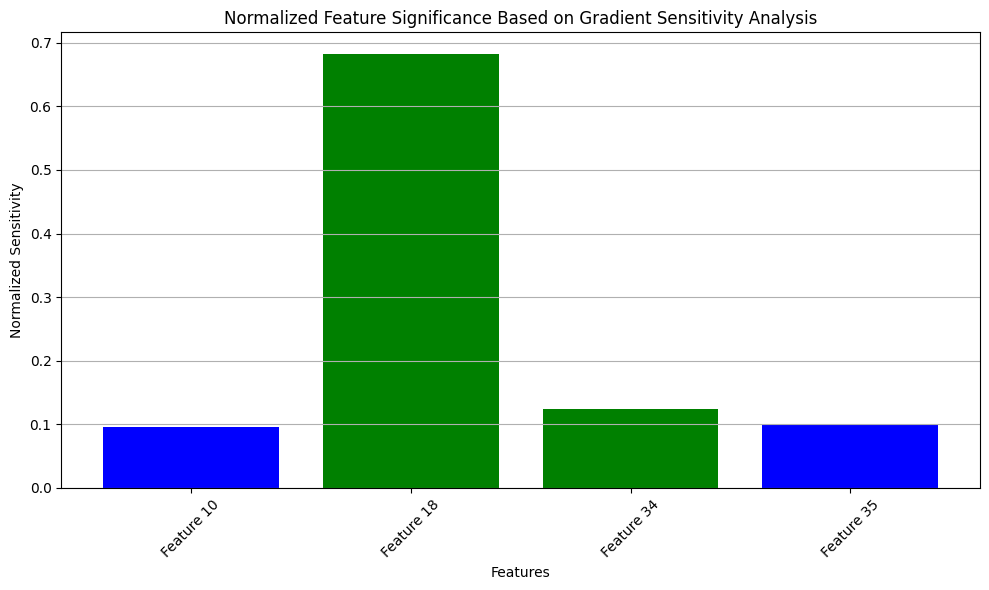

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('27_classifier_ReR1.h5')

# Define the selected features used in training

# Prepare a batch of test data
batch_size = len(X_val)  # Number of samples for sensitivity analysis
X_batch = X_val[:batch_size]  # Select a subset of the test data

# Create a TensorFlow gradient tape to compute gradients
X_batch_tensor = tf.convert_to_tensor(X_batch, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_batch_tensor)
    predictions = model(X_batch_tensor)  # Forward pass through the model
    # Select the positive class probability for binary classification
    output_for_gradients = predictions[:, 0]

# Compute the gradients of the selected output with respect to the input features
gradients = tape.gradient(output_for_gradients, X_batch_tensor)

# Verify gradients are not None
if gradients is None:
    raise ValueError("Gradient computation failed. Ensure the model is differentiable with respect to its inputs.")

# Compute the mean absolute gradient across all samples for each feature
feature_sensitivity = tf.reduce_mean(tf.abs(gradients), axis=[0, 1]).numpy()

# Normalize the sensitivity values so that their sum equals 1
feature_sensitivity_normalized = feature_sensitivity / np.sum(feature_sensitivity)

# Print the sensitivity value for each feature
print("Feature Sensitivity Values (Normalized):")
for i, sensitivity in zip(selected_features, feature_sensitivity_normalized):
    print(f"Feature {i+1}: {sensitivity:.4f}")

import math
# Determine the top 50% most sensitive features using ceil
num_top_features = math.ceil(len(selected_features) / 2)
top_indices = np.argsort(feature_sensitivity_normalized)[-num_top_features:]

# Assign colors: green for top 50%, blue for the rest
bar_colors = ['green' if i in top_indices else 'blue' for i in range(len(selected_features))]

# Plot the normalized feature significance
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_features)), feature_sensitivity_normalized, color=bar_colors)
plt.xticks(range(len(selected_features)), [f'Feature {i+1}' for i in selected_features], rotation=45)
plt.xlabel('Features')
plt.ylabel('Normalized Sensitivity')
plt.title('Normalized Feature Significance Based on Gradient Sensitivity Analysis')
plt.grid(axis='y')
plt.tight_layout()
plt.show()